In [1]:
import time
import math
from keras.models import Sequential
from tensorflow.keras.layers import  LSTM,Dense, Dropout,Activation
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#### Import Data

In [2]:
data = pd.read_csv('nyse_2001-2021.csv')
df=data
df.head()


,Date,Low,Open,Volume,High,Close,Adjusted Close
0,29-11-2001,13.360000,13.386667,371100,14.466667,13.880000,12.583543
1,30-11-2001,13.880000,13.880000,165300,14.266667,14.266667,12.934094
2,03-12-2001,13.783333,14.233333,127500,14.233333,13.783333,12.495903
3,04-12-2001,13.233333,13.783333,95400,13.783333,13.233333,11.997280
4,05-12-2001,13.433333,13.433333,598200,14.783333,14.666667,13.296731


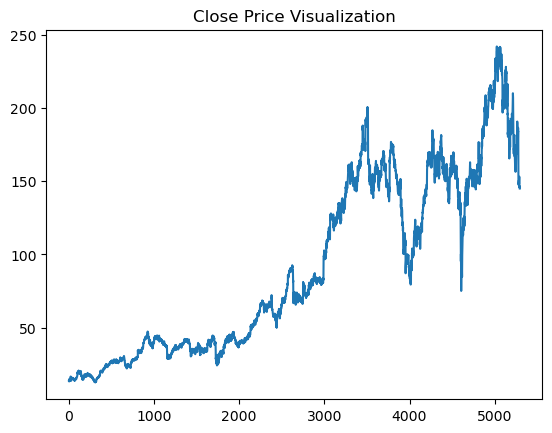

In [3]:
plt.title("Close Price Visualization")
plt.plot(df.Close)

### Defining 200 days moving averages and plotting comparision graph with 100 days moving averages

In [4]:
ma100 = df.Close.rolling(100).mean()
ma100



0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
5291    176.1565
5292    175.7703
5293    175.3297
5294    174.8621
5295    174.4132
Name: Close, Length: 5296, dtype: float64

Text(0.5, 1.0, 'Graph Of Moving Averages Of 100 Days')

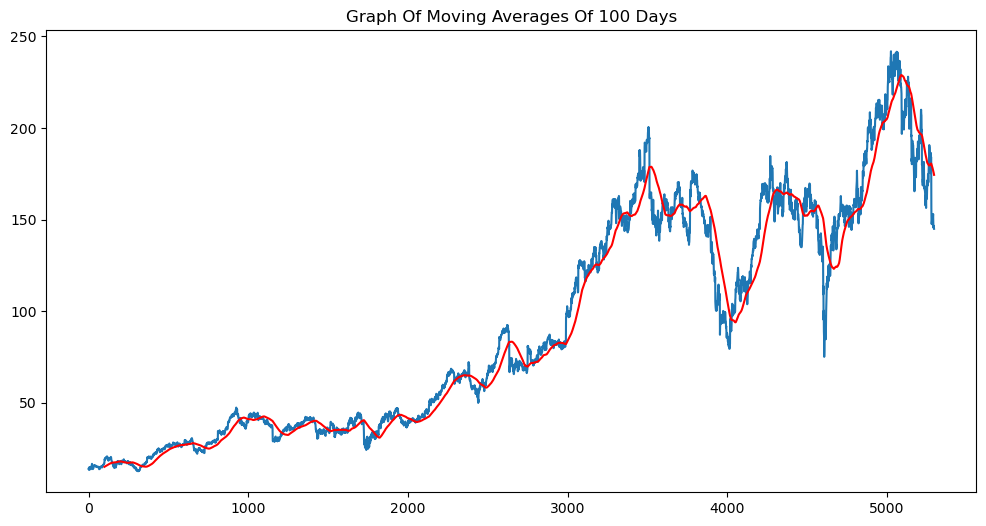

In [5]:
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.title('Graph Of Moving Averages Of 100 Days')

In [6]:
ma200 = df.Close.rolling(200).mean()
ma200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
5291    187.62320
5292    187.32265
5293    187.07160
5294    186.79705
5295    186.49390
Name: Close, Length: 5296, dtype: float64

Text(0.5, 1.0, 'Comparision Of 100 Days And 200 Days Moving Averages')

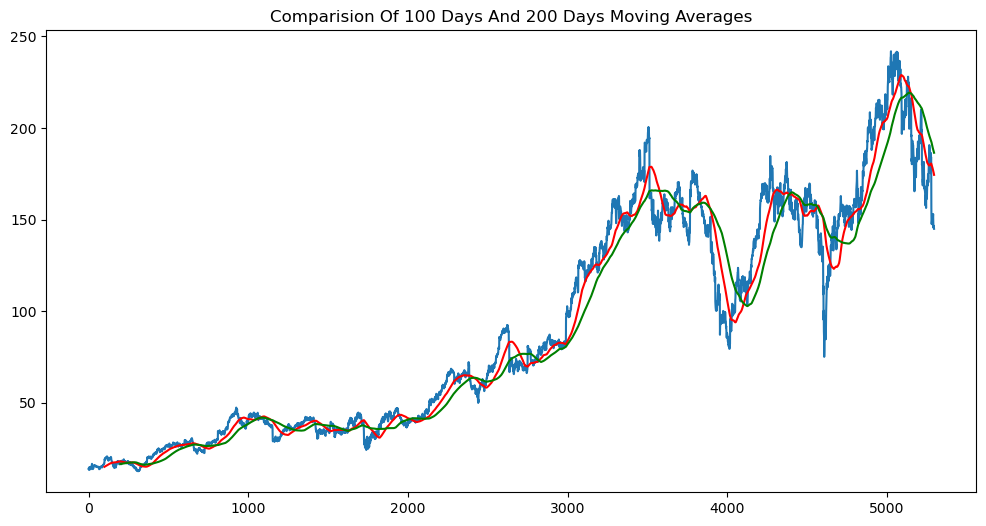

In [7]:

plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')
plt.title('Comparision Of 100 Days And 200 Days Moving Averages')

### Data preprocessing

#### Checking stationarity 

The Dickey-Fuller tests the null hypothesis that a unit root is present in a time series model. The alternative hypothesis is the stationarity of the model.

A time series is said to be stationary if its statistical properties such as mean, variance remain constant over time. The reason why we verify time series stationarity is because we cannot build a time series model if the time series is not stationary. Let's verify that the time series is stationary.

In [27]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
plt.figure(figsize = (10,6))

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

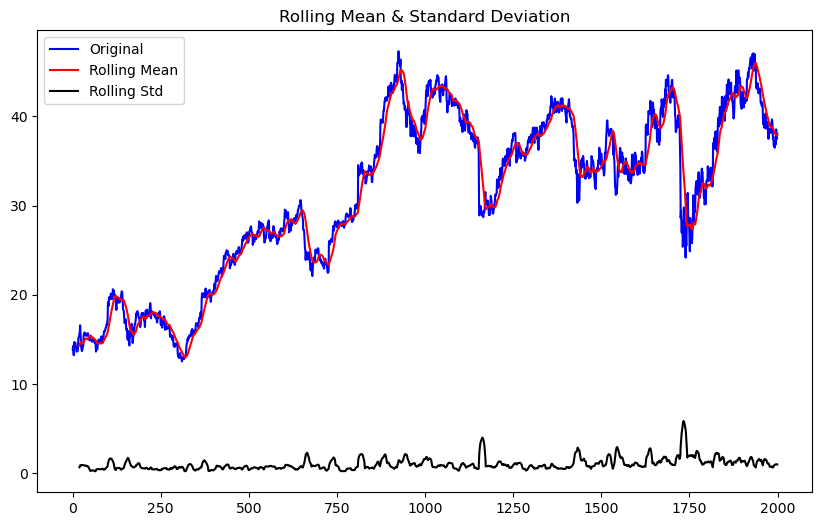

Results of Dickey-Fuller Test:
Test Statistic                   -2.025371
p-value                           0.275561
#Lags Used                       22.000000
Number of Observations Used    1977.000000
Critical Value (1%)              -3.433662
Critical Value (5%)              -2.863003
Critical Value (10%)             -2.567549
dtype: float64


In [28]:
#Checking stationarity 
# we will use the rolling statistics plots along with augmented Dickey-Fuller test results.

df_close = df['Close']

plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

On the above graph, we can see that the rolling mean is increasing. Thus, the time series is not stationary.
Regarding the test statistic used in the augmented Dickey-Tuller statistic, it is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.
Here, -2.025 is greater than the -2.86 critical value at the 95% 
  confidence bound. Therefore, we can confirm that the null hypotheis cannot be rejected.


<Figure size 640x480 with 0 Axes>

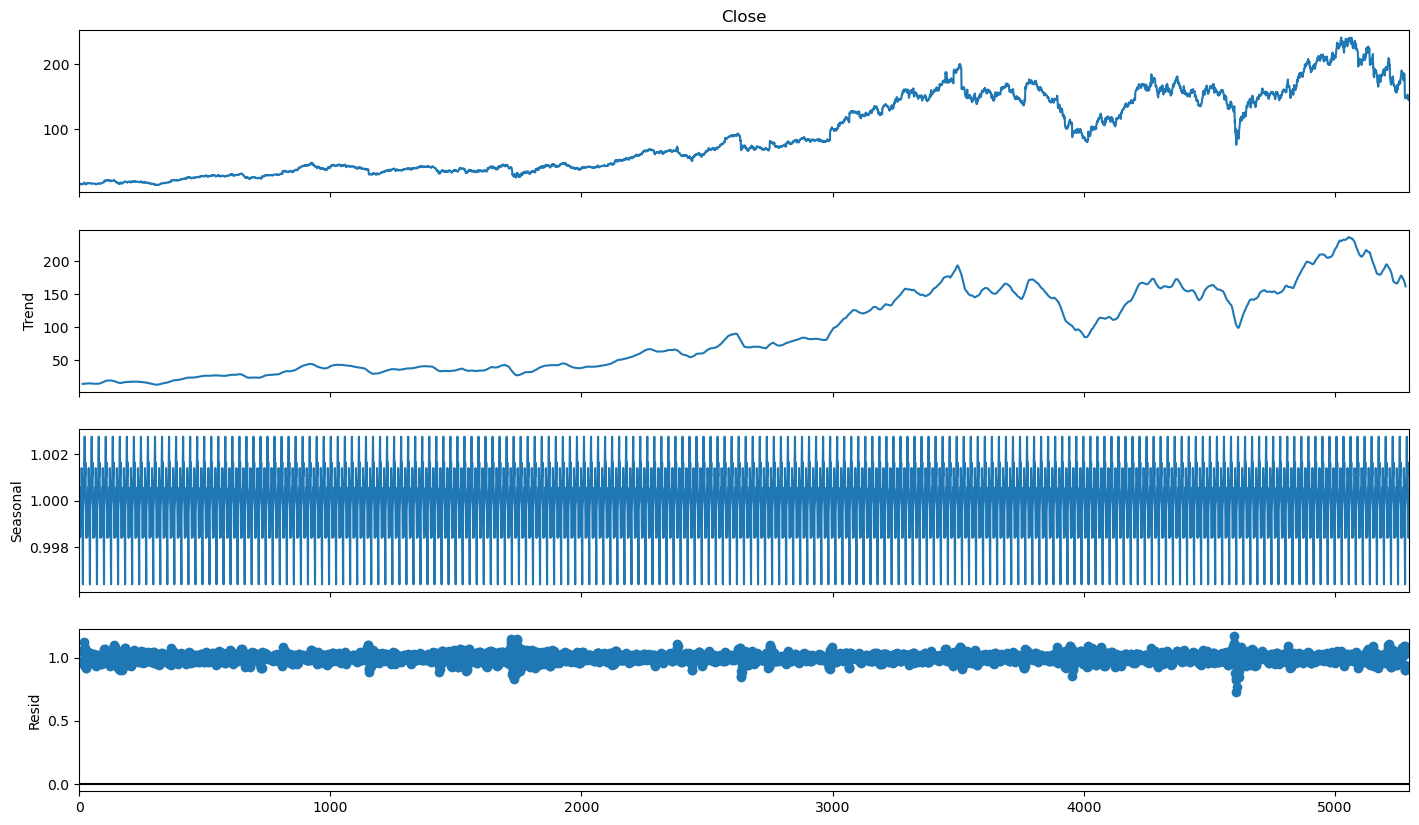

In [30]:
#To plot the trend and the seasonality
# We set the period to 28 as we have in average 7*4 = 28 days in a month
# The result below is just to have a first visualization of trend and seasonality. 
# Here we take a monthly average but to forecast a stock  price, it is more difficult than that to choose the right number of days to average on

from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

Text(0.5, 1.0, 'Transformed data')

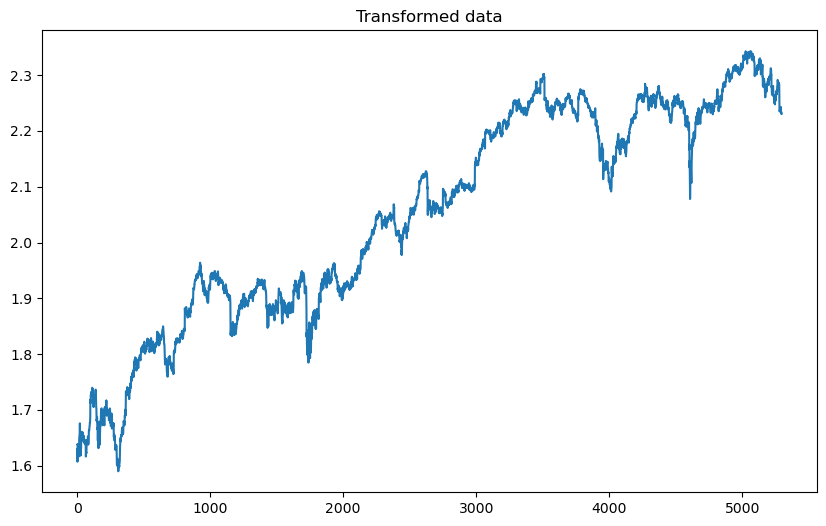

In [31]:
# As the time series is constantly increasing, we apply a log transform, and a square root transform to flatten it.

df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

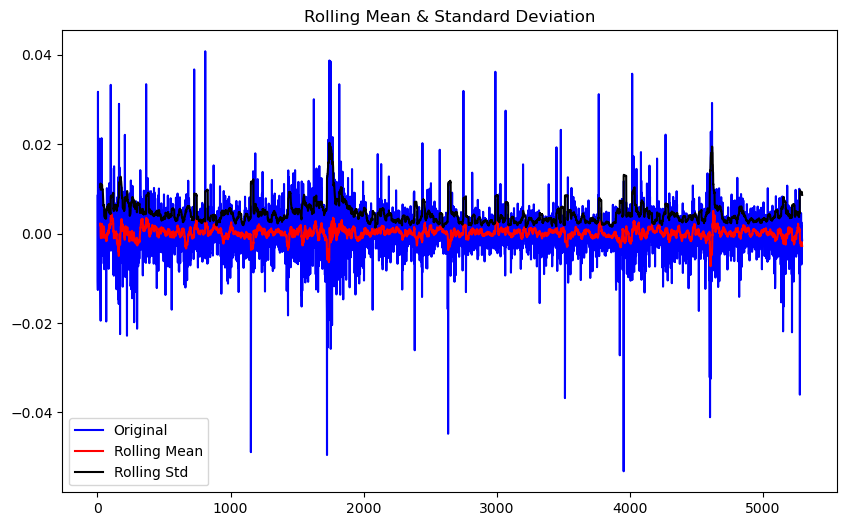

Results of Dickey-Fuller Test:
Test Statistic                  -72.988895
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    5294.000000
Critical Value (1%)              -3.431586
Critical Value (5%)              -2.862086
Critical Value (10%)             -2.567061
dtype: float64


In [33]:
#Let's know use one classical method to deal with trend and seasonality: differenciating. 
# We take the difference of the observation at a particular instant with that at the previous instant.


from statsmodels.tsa.stattools import adfuller

df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

We obtain significally better results:

The test statistic is a lot lower than the critical value at 1%. Therefore, we can say with more than 99% confidence that this is a stationary series. Moreover, as the p-value is inferior to the 5% threshold, the null hypothesis is rejected, meaning that the Dickey-Fuller test is verified. Thus, the time series is stationary.

# Spliting the dataset into training,testing and validation dataset

In [34]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix >= len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
        
    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

In [35]:
# choose the number of days on which to base our predictions 
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

In [36]:
#Split the data set between the training set and the test set
test_days = 1050 

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

In [37]:
X_train.shape

(4185, 60, 1)

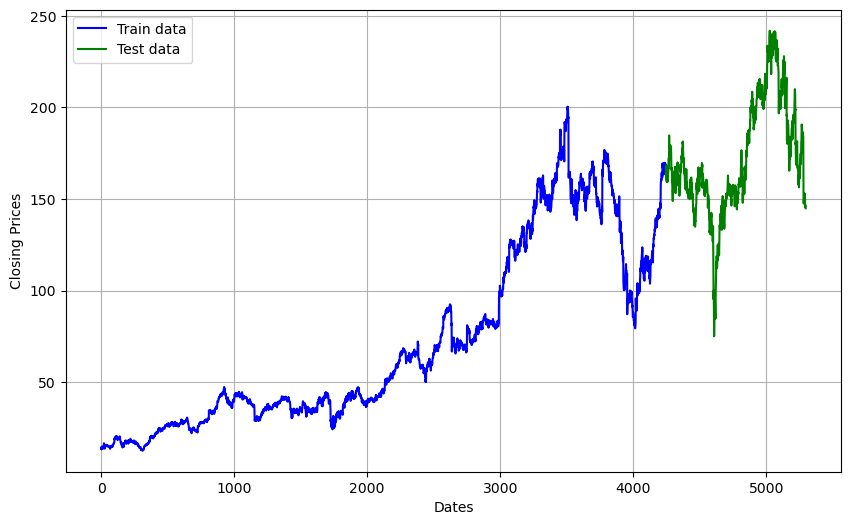

In [38]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [39]:
#create validation dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2,shuffle = True)

In [40]:
X_train.shape

(3348, 60, 1)

In [41]:
X_val.shape

(837, 60, 1)

In [42]:
X_test.shape

(1050, 60, 1)

In [43]:
y_train.shape

(3348,)

### Creating LSTM Model

In [44]:
# LSTM architecture

model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.1))


model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.2))


model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))


model.add(LSTM(units = 100, activation = 'relu'))
model.add(Dropout(0.4))

model.add(Dense(units = 1))

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 dropout_4 (Dropout)         (None, 60, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 60, 60)            26640     
                                                                 
 dropout_5 (Dropout)         (None, 60, 60)            0         
                                                                 
 lstm_6 (LSTM)               (None, 60, 80)            45120     
                                                                 
 dropout_6 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_7 (LSTM)               (None, 100)              

#### Training the model


In [47]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['MAE'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model.fit(X_train, y_train,validation_data = (X_val, y_val), epochs =25, callbacks=[early_stopping],verbose=1)

Epoch 1/25
105/105 [==============================] - 19s 121ms/step - loss: 2.7273e-05 - MAE: 0.0034 - val_loss: 3.1292e-05 - val_MAE: 0.0034
Epoch 2/25
105/105 [==============================] - 12s 112ms/step - loss: 2.6630e-05 - MAE: 0.0034 - val_loss: 3.1447e-05 - val_MAE: 0.0034
Epoch 3/25
105/105 [==============================] - 12s 114ms/step - loss: 2.6531e-05 - MAE: 0.0034 - val_loss: 3.1326e-05 - val_MAE: 0.0034
Epoch 4/25
105/105 [==============================] - 12s 113ms/step - loss: 2.6682e-05 - MAE: 0.0034 - val_loss: 3.1424e-05 - val_MAE: 0.0034
Epoch 5/25
105/105 [==============================] - 13s 120ms/step - loss: 2.6752e-05 - MAE: 0.0034 - val_loss: 3.1479e-05 - val_MAE: 0.0035
Epoch 6/25
105/105 [==============================] - 12s 119ms/step - loss: 2.6730e-05 - MAE: 0.0034 - val_loss: 3.1288e-05 - val_MAE: 0.0034
Epoch 7/25
105/105 [==============================] - 13s 125ms/step - loss: 2.6594e-05 - MAE: 0.0034 - val_loss: 3.1356e-05 - val_MAE: 0.0034

#### Testing the model


In [48]:
# Making predictions
# Evaluate the model on the test data using
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])


Evaluate on test data
33/33 [==============================] - 1s 30ms/step - loss: 2.5635e-05 - MAE: 0.0034
Test MSE: 2.563485031714663e-05
Test MAE: 0.003400112735107541


### Predictions

33/33 [==============================] - 2s 30ms/step


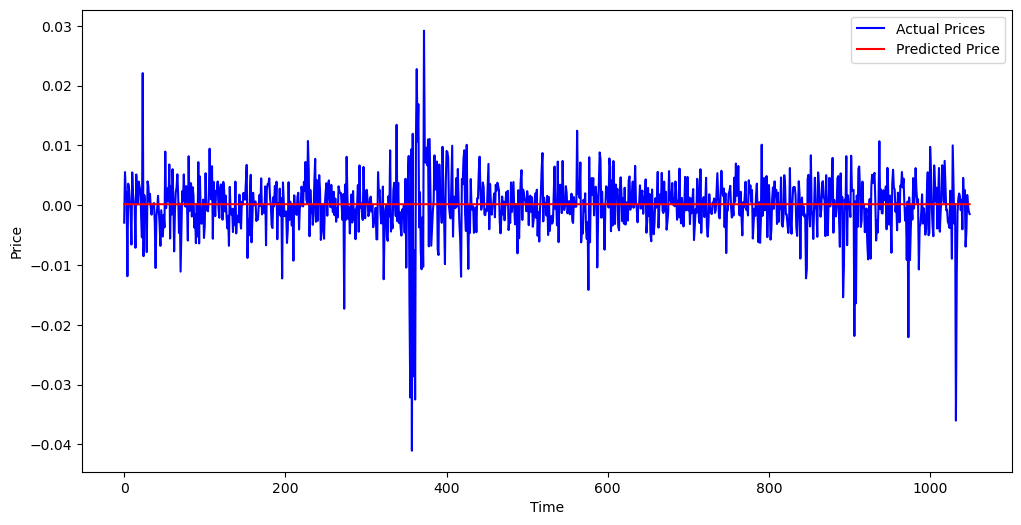

In [49]:
# Prediction
y_pred = model.predict(X_test)

plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "Actual Prices")
plt.plot(y_pred, 'r', label = "Predicted Price")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

After calling model.predict(), we need to apply the inverse transformations to the predicted data to be able to compare our predictions with the original data.



In [50]:
# We create a dataframe from y_pred to have date-time indexes.
pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

# Apply inverse transformation from 1.d

# Add the differenciation term
pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:] 

# Take the square, and the exponent
pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)

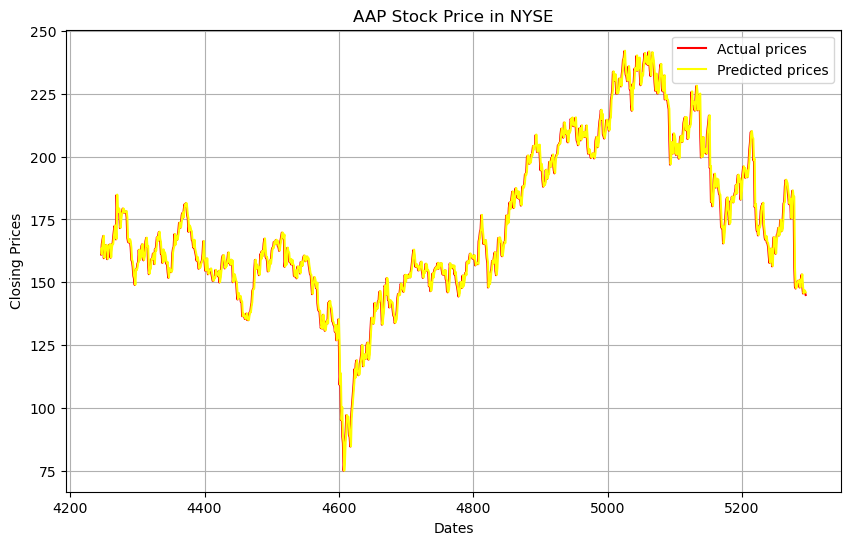

In [65]:
# Plot actual prices vs predicted prices 
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'r',label='Actual prices')
plt.plot(pred_data,'yellow',label='Predicted prices')
plt.title("AAP"+ ' Stock Price in NYSE')

plt.legend()

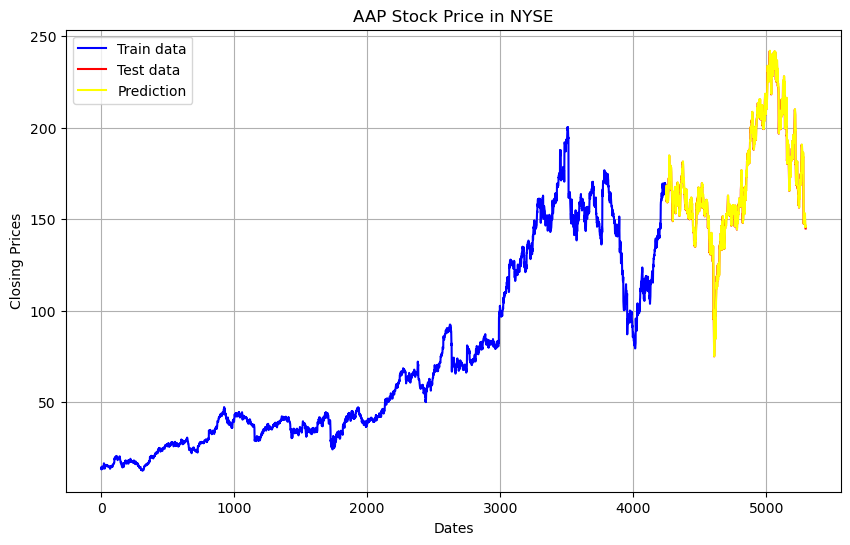

In [60]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'red', label='Test data')
plt.plot(pred_data, 'yellow', label='Prediction')
plt.title('AAP Stock Price in NYSE')
plt.legend()